In [234]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir
from keras.preprocessing import sequence
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
import keras
from keras.layers import LSTM

from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import ModelCheckpoint

In [235]:
df_walk = pd.read_csv('Walking_Data.csv')
df_fall = pd.read_csv('Falling_Data.csv')
df_walk.columns=['timestamp','x','y','z','subject','trial','tag']
df_fall.columns=['timestamp','x','y','z','subject','trial','tag']

len(df_walk)

48164

In [236]:
df_walk=df_walk.dropna()
df_fall=df_fall.dropna()
df_walk[~df_walk.isin([np.nan, np.inf, -np.inf]).any(1)]
df_fall[~df_fall.isin([np.nan, np.inf, -np.inf]).any(1)]

len(df_walk)

48164

In [237]:
sequences_fall=[]
#both data got 2 person with no data so manually removed in excel
for subject in range(1,16):
    for trial in range(1,4):
        temp=df_fall.loc[(df_fall['subject'] == subject) & (df_fall['trial']==trial)]
        temp=temp.drop(['timestamp','subject','trial','tag'],axis=1)
        if temp.empty==False:
            sequences_fall.append(temp.values.tolist())


        
sequences_walk=[]
for subject in range(1,16):
    for trial in range(1,4):
        temp=df_walk.loc[(df_walk['subject'] == subject) & (df_walk['trial']==trial)]
        temp=temp.drop(['timestamp','subject','trial','tag'],axis=1)
        if temp.empty==False:
            sequences_walk.append(temp.values.tolist())

In [238]:
len(sequences_fall)

39

In [239]:
len_sequences_fall = []
for one_seq in sequences_fall:
    len_sequences_fall.append(len(one_seq))
pd.Series(len_sequences_fall).describe()

count     39.000000
mean     180.948718
std       11.283310
min      149.000000
25%      177.000000
50%      184.000000
75%      187.500000
max      195.000000
dtype: float64

In [240]:
#Padding the sequence with the values in last row to max length
to_pad_fall = 195
new_seq = []
for one_seq in sequences_fall:
    len_one_seq = len(one_seq)
    last_val = one_seq[-1]
    n = to_pad_fall - len_one_seq
   
    to_concat = np.repeat(one_seq[-1], n).reshape(3, n).transpose()
    new_one_seq = np.concatenate([one_seq, to_concat])
    new_seq.append(new_one_seq)
final_seq_fall = np.stack(new_seq)

#truncate the sequence to length 60
from keras.preprocessing import sequence
seq_len = 187
final_seq_fall=sequence.pad_sequences(final_seq_fall, maxlen=seq_len, padding='post', dtype='float', truncating='post')

In [241]:
len_sequences_walk = []
for one_seq in sequences_walk:
    len_sequences_walk.append(len(one_seq))
pd.Series(len_sequences_walk).describe()

count      39.000000
mean     1077.743590
std        67.402842
min       898.000000
25%      1054.000000
50%      1094.000000
75%      1125.500000
max      1145.000000
dtype: float64

In [242]:
#Padding the sequence with the values in last row to max length
to_pad_walk = 1145
new_seq = []
for one_seq in sequences_walk:
    len_one_seq = len(one_seq)
    last_val = one_seq[-1]
    n = to_pad_walk - len_one_seq
    to_concat = np.repeat(one_seq[-1], n).reshape(3, n).transpose()
    new_one_seq = np.concatenate([one_seq, to_concat])
    new_seq.append(new_one_seq)
    
final_seq_walk = np.stack(new_seq)
from keras.preprocessing import sequence
seq_len = 187
final_seq_walk=sequence.pad_sequences(final_seq_walk, maxlen=seq_len, padding='post', dtype='float', truncating='post')

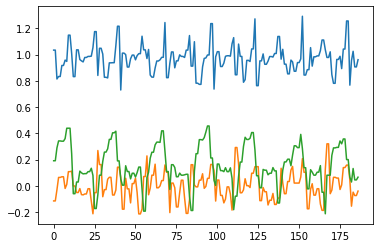

In [243]:
x=11
plt.plot(final_seq_walk[x])


In [244]:
label_walk=np.array(range(len(final_seq_walk)))*0  
label_fall=np.array(range(len(final_seq_fall)))*0+1


In [245]:
final_seq=np.concatenate((final_seq_fall,final_seq_walk),axis=0)
final_label=np.concatenate((label_fall,label_walk),axis=0)
len(final_label)


78

In [246]:
x_min = final_seq.min(axis=(1, 2), keepdims=True)
x_max = final_seq.max(axis=(1, 2), keepdims=True)

final_x = (final_seq - x_min)/(x_max-x_min)


In [248]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(final_x, final_label, test_size=0.3, random_state=42)

In [249]:
model = Sequential()
model.add(LSTM(4,return_sequences=True, input_shape=(seq_len, 3)))
model.add(LSTM(4))

model.add(Dense(1, activation='sigmoid'))

In [ ]:
adam = Adam(lr=0.001)
chk = ModelCheckpoint('best_model.pkl', monitor='val_acc', save_best_only=True, mode='max', verbose=1)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
history=model.fit(X_train, y_train, epochs=50, batch_size=32, callbacks=[chk], validation_data=(X_test,y_test))


Train on 54 samples, validate on 24 samples
Epoch 1/50


In [ ]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.save("modelx_val.h5")

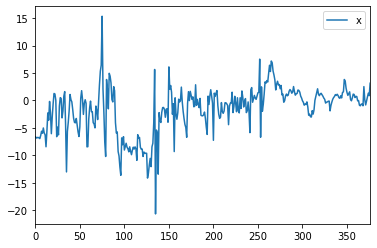